In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.transform
import itertools as it
import multiprocessing as mp

In [2]:
imname = 'monastery.jpg'

In [3]:
im = skio.imread(imname)

In [4]:
im = sk.img_as_float(im)

In [5]:
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(np.int)

In [6]:
# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

In [23]:
def metric(x1, x2):
    return np.sum((x1 - x2)**2)

# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)
def crop_and_combine(im):
    height = np.floor(im.shape[0]/3.0).astype(np.int)
    width = int(im.shape[1])
    
    # first 1/3 of img is blue, middle is green, last 1/3 is red. We crop it by 1/10
    b = im[:height]
    b = b[height//10:height*9//10, width//10:width*9//10]
    g = im[height: 2*height]
    g = g[height//10:height*9//10, width//10:width*9//10]
    r = im[2*height: 3*height]
    r = r[height//10:height*9//10, width//10:width*9//10]
    
    ag = None
    ar = None
    ag_loss = float("inf")
    ar_loss = float("inf")
    best_xy_g = None
    best_xy_r = None
    
    # search between the range of width/10 and height/10
    # translate by x, y
    # calculate metric of blue and translated image
    # if the loss is less, save the loss and the translation as the "best"
    for x in range(-width//10, width//10 + 1):
        for y in range(-height//10, height//10 + 1):
            gb = np.roll(g, x, axis=1)
            gb = np.roll(gb, y, axis=0)
            rb = np.roll(r, x, axis=1)
            rb = np.roll(rb, y, axis=0)

            gb_loss = metric(gb, b)
            rb_loss = metric(rb, b)

            if gb_loss < ag_loss:
                ag = gb
                best_xy_g = np.array([x, y])
                ag_loss = gb_loss
            if rb_loss < ar_loss:
                ar = rb
                best_xy_r = np.array([x, y])
                ar_loss = rb_loss

    im_out = np.dstack([ar, ag, b])
    return (best_xy_g, best_xy_r), im_out

In [10]:
def roll_and_metric(key, blue, color):
    color = np.roll(color, key[0], axis=1)
    color = np.roll(color, key[1], axis=0)
    return metric(color, blue)

#if i import multithread support library, map can be done in parallel with cores
def get_pyramid_alignment(color, blue):
    print("looping: " + str(0) + " x " + str(4))
#     best_xy = None
#     loss = float("inf")
#     for x in range(0, 5):
#         for y in range(0, 5):
#             translated = np.roll(color, x, axis = 1)
#             translated = np.roll(translated, y, axis = 0)
#             l = metric(translated, blue)
#             if l < loss:
#                 loss = l
#                 best_xy = (x, y)
#     return best_xy
    x = list(range(0, 5))
    y = list(range(0, 5))
    ranges = [x, y]
    ranges = list(it.product(*ranges)) # ex for product: given [1, 2] and [1, 2] returns [[1, 1], [1, 2], [2, 1], [2, 2]]
    # this basically does what the commented for loop does, but in parallel (if you use multithread library properly)
    # starmap froze on map though so I used the default map function which is the same speed as the for loops
    losses = list(map(roll_and_metric, ranges, [blue for i in ranges], [color for i in ranges]))
    ind = losses.index(min(losses))
    return ranges[ind]
    

def pyramid_search(im):
    print("in pyramid_search")
    height = np.floor(im.shape[0]/3.0).astype(np.int)
    width = int(im.shape[1])
    
    #cropping
    orig_b = im[:height]
    b = orig_b[orig_b.shape[0]//10:orig_b.shape[0] * 9//10, orig_b.shape[1]//10:orig_b.shape[1] * 9//10]
    
    orig_g = im[height: 2*height]
    g = orig_g[orig_g.shape[0]//10:orig_g.shape[0] * 9//10, orig_g.shape[1]//10:orig_g.shape[1] * 9//10]
    
    orig_r = im[2*height: 3*height]
    r = orig_r[orig_r.shape[0]//10:orig_r.shape[0] * 9//10, orig_r.shape[1]//10:orig_r.shape[1] * 9//10]
    
    pyr_b = []
    pyr_g = []
    pyr_r = []
    
    pyr_b.append(b)
    pyr_g.append(g)
    pyr_r.append(r)
    
    current_size = min(b.shape[0]//2, b.shape[1]//2)
    
    print("beginning building pyramids...")
    # for each level, save the half-scaled image until pixel size is less than 50
    while current_size > 50:
        b, g, r = map(lambda im: sk.transform.rescale(im, 0.5), (b, g, r))
        pyr_b.insert(0, b)
        pyr_g.insert(0, g)
        pyr_r.insert(0, r)
        current_size = current_size//2
    
    print("finished building pyramids...")
    levels = len(pyr_b)
    print("there are " + str(levels) + " levels")
    
    
    dx_g = 0
    dy_g = 0
    dx_r = 0
    dy_r = 0
    for i in range(levels):
        print("on " + str(i) + "th level")
        # each image is scaled by a factor of 2 for every level in the pyramid, so we scale up the translation appropriately
        dx_g *= 2
        dy_g *= 2
        dx_r *= 2
        dy_r *= 2
          
        translate_g = np.roll(pyr_g[i], dx_g, axis=1)
        translate_g = np.roll(translate_g, dy_g, axis=0)
        translate_r = np.roll(pyr_r[i], dx_r, axis=1)
        translate_r = np.roll(translate_r, dy_r, axis=0)
        # get alignment 
        g_res, r_res = map(get_pyramid_alignment, (translate_g, translate_r), (pyr_b[i], pyr_b[i]))
          
            
        # update alignment
        dx_g += g_res[0]
        dy_g += g_res[1]
        dx_r += r_res[0]
        dy_r += r_res[1]
          
        print("dx_g: " + str(dx_g))
        print("dy_g: " + str(dy_g))
        print("dx_r: " + str(dx_r))
        print("dy_r: " + str(dy_r))
    
    print("finished finding best dx and dy...")
    # translate by the best dx dy for red and green
    trans_g = np.roll(orig_g, dx_g, axis=1)
    trans_g = np.roll(trans_g, dy_g, axis=0)
    
    trans_r = np.roll(orig_r, dx_r, axis=1)
    trans_r = np.roll(trans_r, dy_r, axis=0)
    
    # one final crop before we stack channels
    cropped_b = orig_b[orig_b.shape[0]//10:orig_b.shape[0]*9//10, orig_b.shape[1]//10:orig_b.shape[1]*9//10]
    cropped_g =  trans_g[trans_g.shape[0]//10:trans_g.shape[0]*9//10, trans_g.shape[1]//10:trans_g.shape[1]*9//10]
    cropped_r =  trans_r[orig_r.shape[0]//10:trans_r.shape[0]*9//10, trans_r.shape[1]//10:trans_r.shape[1]*9//10]

    
    print("finished translating and cropping final image...")
    
    return (dx_g, dy_g, dx_r, dy_r), np.dstack([cropped_r, cropped_g, cropped_b])
    

In [11]:
im = sk.img_as_float(skio.imread(imname))
fname = 'out_fname.jpg'
best_xy, im_out = crop_and_combine(im)
skio.imsave(fname, im_out)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


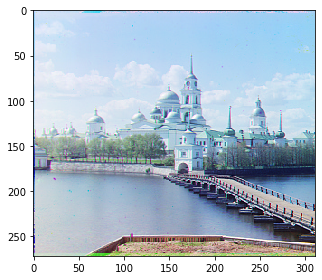

In [12]:
skio.imshow(im_out)
skio.show()

In [13]:
im = sk.img_as_float(skio.imread("melons.tif"))
fname = 'out_fname2.jpg'
best_xy, im_out = pyramid_search(im)
skio.imsave(fname, im_out)

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 3
dx_r: 0
dy_r: 4
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 6
dx_r: 1
dy_r: 11
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 12
dx_r: 2
dy_r: 22
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 24
dx_r: 4
dy_r: 45
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 48
dx_r: 8
dy_r: 90
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 96
dx_r: 16
dy_r: 180
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


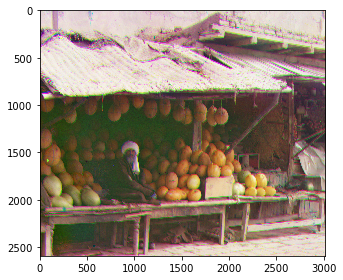

In [14]:
skio.imshow(im_out)
skio.show()

In [15]:
im_out = np.round(im_out*255).astype(np.uint8)
skio.imsave("melons.jpg", im_out)

In [21]:
jpg_file_names = ["cathedral", "monastery", "tobolsk", "
                  
                  "]
tif_file_names = ["church", "emir", "harvesters", "icon", "lady", 
                  "melons", "onion_church", "self_portrait", 
                  "three_generations", "train", "workshop", "Siren"]

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (array([2, 5]), array([ 3, 12]))


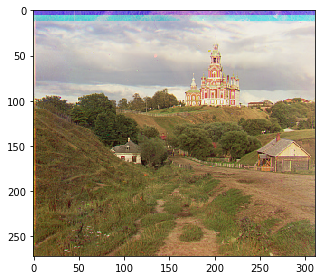

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (array([ 2, -3]), array([2, 3]))


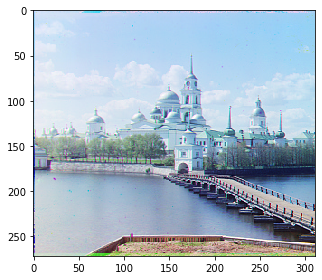

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (array([3, 3]), array([3, 6]))


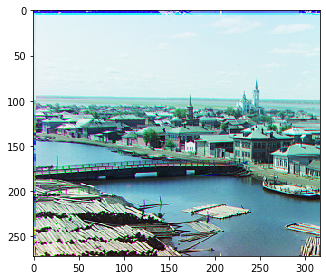

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (array([0, 2]), array([1, 5]))


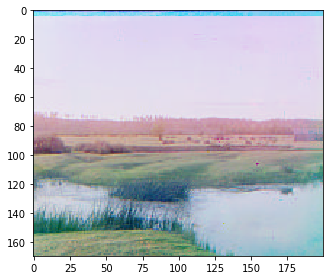

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 0
dx_r: 0
dy_r: 2
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 1
dx_r: 0
dy_r: 4
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 3
dx_r: 0
dy_r: 8
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 6
dx_r: 0
dy_r: 16
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 12
dx_r: 0
dy_r: 32
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 25
dx_r: 0
dy_r: 64
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (4, 25, 0, 64)


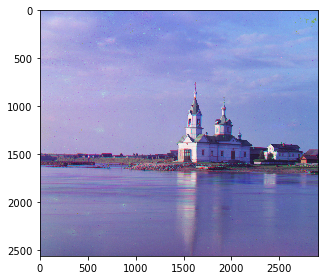

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 1
dx_r: 2
dy_r: 3
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 3
dx_r: 4
dy_r: 6
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 6
dx_r: 8
dy_r: 13
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 12
dx_r: 16
dy_r: 26
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 25
dx_r: 32
dy_r: 52
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 32
dy_g: 50
dx_r: 64
dy_r: 104
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (32, 50, 64, 104)


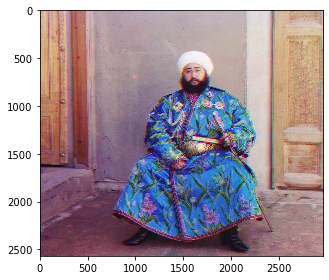

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 2
dx_r: 0
dy_r: 4
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 4
dx_r: 1
dy_r: 8
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 8
dx_r: 2
dy_r: 16
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 16
dx_r: 4
dy_r: 32
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 32
dx_r: 8
dy_r: 64
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 32
dy_g: 64
dx_r: 16
dy_r: 128
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (32, 64, 16, 128)


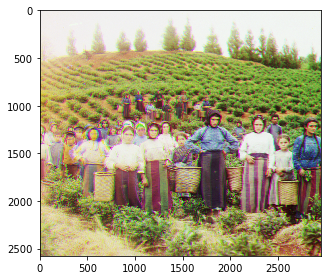

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 1
dx_r: 1
dy_r: 3
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 3
dx_r: 2
dy_r: 6
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 6
dx_r: 4
dy_r: 12
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 12
dx_r: 8
dy_r: 24
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 24
dx_r: 16
dy_r: 48
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 32
dy_g: 48
dx_r: 32
dy_r: 96
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (32, 48, 32, 96)


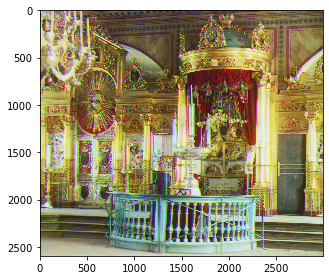

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 1
dx_r: 0
dy_r: 3
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 3
dx_r: 1
dy_r: 7
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 6
dx_r: 2
dy_r: 14
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 12
dx_r: 4
dy_r: 28
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 24
dx_r: 8
dy_r: 56
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 48
dx_r: 16
dy_r: 112
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (16, 48, 16, 112)


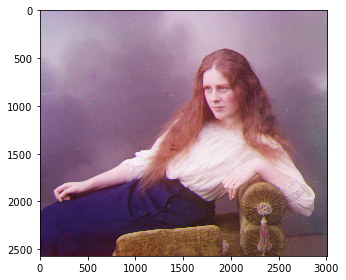

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 3
dx_r: 0
dy_r: 4
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 6
dx_r: 1
dy_r: 11
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 12
dx_r: 2
dy_r: 22
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 24
dx_r: 4
dy_r: 45
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 48
dx_r: 8
dy_r: 90
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 96
dx_r: 16
dy_r: 180
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (16, 96, 16, 180)


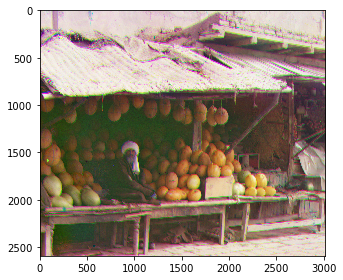

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 1
dx_r: 1
dy_r: 3
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 3
dx_r: 2
dy_r: 7
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 6
dx_r: 4
dy_r: 14
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 12
dx_r: 9
dy_r: 28
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 25
dx_r: 18
dy_r: 56
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 32
dy_g: 50
dx_r: 36
dy_r: 112
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (32, 50, 36, 112)


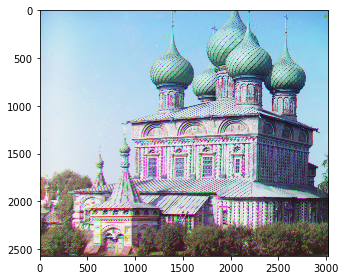

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 2
dx_r: 1
dy_r: 4
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 5
dx_r: 2
dy_r: 11
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 10
dx_r: 5
dy_r: 22
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 20
dx_r: 10
dy_r: 44
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 40
dx_r: 20
dy_r: 88
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 32
dy_g: 80
dx_r: 40
dy_r: 177
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (32, 80, 40, 177)


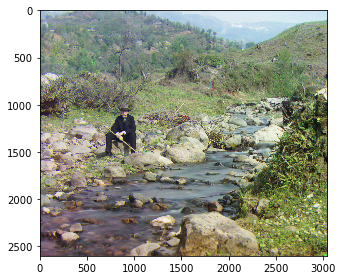

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 2
dx_r: 0
dy_r: 4
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 4
dx_r: 1
dy_r: 8
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 8
dx_r: 2
dy_r: 16
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 16
dx_r: 4
dy_r: 32
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 32
dx_r: 8
dy_r: 64
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 16
dy_g: 64
dx_r: 16
dy_r: 128
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (16, 64, 16, 128)


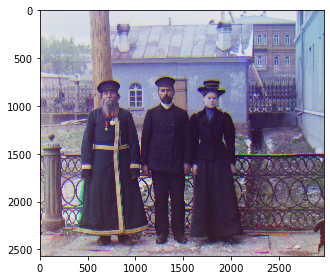

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 1
dx_r: 1
dy_r: 3
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 3
dx_r: 2
dy_r: 6
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 1
dy_g: 6
dx_r: 4
dy_r: 12
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 2
dy_g: 12
dx_r: 8
dy_r: 24
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 4
dy_g: 24
dx_r: 16
dy_r: 48
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 8
dy_g: 48
dx_r: 33
dy_r: 96
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (8, 48, 33, 96)


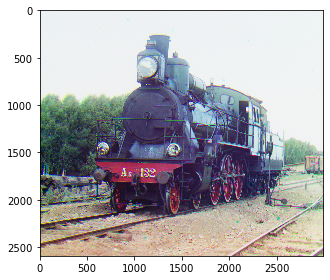

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 1
dx_r: 0
dy_r: 3
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 3
dx_r: 0
dy_r: 6
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 6
dx_r: 0
dy_r: 13
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 13
dx_r: 0
dy_r: 26
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 26
dx_r: 0
dy_r: 52
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 53
dx_r: 0
dy_r: 105
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (0, 53, 0, 105)


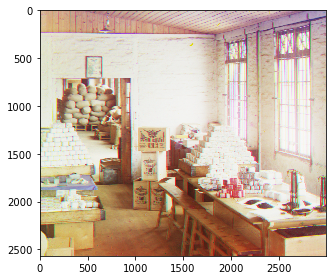

in pyramid_search
beginning building pyramids...
finished building pyramids...
there are 6 levels
on 0th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 2
dx_r: 0
dy_r: 3
on 1th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 4
dx_r: 0
dy_r: 6
on 2th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 8
dx_r: 0
dy_r: 12
on 3th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 16
dx_r: 0
dy_r: 24
on 4th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 32
dx_r: 0
dy_r: 48
on 5th level
looping: 0 x 4
looping: 0 x 4
dx_g: 0
dy_g: 64
dx_r: 0
dy_r: 96
finished finding best dx and dy...
finished translating and cropping final image...


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


best dx: (0, 64, 0, 96)


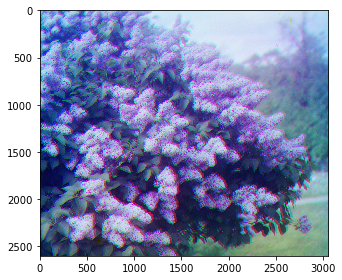

In [24]:
for name in jpg_file_names:
    im = sk.img_as_float(skio.imread(name + ".jpg"))
    fname = "colored_" + name + ".jpg"
    best_xy, im_out = crop_and_combine(im)
    print("best dx: " + str(best_xy))
    skio.imsave(fname, im_out)
    skio.imshow(im_out)
    skio.show()

for name in tif_file_names:
    im = sk.img_as_float(skio.imread(name + ".tif"))
    fname = name + ".jpg"
    best_xy, im_out = pyramid_search(im)
    print("best dx: " + str(best_xy))
    skio.imsave(fname, im_out)
    skio.imshow(im_out)
    skio.show()